In [1]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

os.environ['LOKY_MAX_CPU_COUNT'] = '4'  # Set the number of cores you want to use (change to your preference)


# Undersampling:
    
Undersampling involves randomly removing samples from the majority class to achieve a balanced class distribution.
One common method is random undersampling, where you randomly select a subset of the majority class samples.


In [2]:
df = pd.read_csv('12_removed_all_nan_with_mean.csv', low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155766 entries, 0 to 155765
Data columns (total 36 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   census_tract                              155766 non-null  float64
 1   action_taken                              155766 non-null  int64  
 2   loan_type                                 155766 non-null  int64  
 3   lien_status                               155766 non-null  int64  
 4   reverse_mortgage                          155766 non-null  int64  
 5   open_end_line_of_credit                   155766 non-null  int64  
 6   loan_amount                               155766 non-null  int64  
 7   combined_loan_to_value_ratio              155766 non-null  float64
 8   interest_rate                             155766 non-null  float64
 9   total_loan_costs                          155766 non-null  float64
 10  origination_charges 

In [4]:
X = df.drop('action_taken', axis=1)
y = df['action_taken']

In [5]:
# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic regression

In [6]:
# Train a logistic regression model on the resampled training data
model1 = LogisticRegression()
model1.fit(X_train, y_train)

LogisticRegression()

In [7]:
# Make predictions on the test set
y_pred1 = model1.predict(X_test)

In [8]:
# Calculate and print the classification report
report1 = classification_report(y_test, y_pred1, zero_division=1)

print(report1)

              precision    recall  f1-score   support

           1       0.56      0.60      0.58     15618
           3       0.57      0.53      0.55     15536

    accuracy                           0.56     31154
   macro avg       0.56      0.56      0.56     31154
weighted avg       0.56      0.56      0.56     31154



# Logistic regression with regularisation

In [9]:
# Create a regularized logistic regression model with L2 regularization
model3 = LogisticRegression(penalty='l2', C=1.0)

# Fit the model on the resampled training data
model3.fit(X_train, y_train)

# Make predictions on the test set
y_pred3 = model3.predict(X_test)

# Calculate and print the classification report
report3 = classification_report(y_test, y_pred3, zero_division=1)
print(report3)

              precision    recall  f1-score   support

           1       0.56      0.60      0.58     15618
           3       0.57      0.53      0.55     15536

    accuracy                           0.56     31154
   macro avg       0.56      0.56      0.56     31154
weighted avg       0.56      0.56      0.56     31154



# Conclusion

It seems that the model is performing poorly in terms of precision, recall, and F1-score, especially for classes 0 and 3. 
The extremely low values for precision, recall, and F1-score for class 0 indicate that the model is unable to make 
meaningful predictions for that class, likely due to a lack of true samples in the test set.

The AUC-ROC value of 0.9177 indicates that the model's ability to distinguish between positive and negative instances 
is relatively good, but this metric can be misleading when dealing with imbalanced datasets.

The Precision-Recall AUC of 0.6182 suggests that the model's performance in terms of precision and recall trade-off is 
suboptimal, and there is room for improvement.

# SMOTE-ENN (Synthetic Minority Over-sampling Technique - Edited Nearest Neighbors): 
    
This technique first oversamples the minority class using SMOTE and then removes 
noisy samples by applying Edited Nearest Neighbors (ENN) to the combined dataset. 
It's a good choice if you suspect that there are noisy samples in your majority class 
that you want to remove.

In [10]:
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.datasets import make_classification

# Create a SMOTE-ENN instance
smote_enn = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))

# Fit and resample your training data
X_resampled, y_resampled = smote_enn.fit_resample(X_train, y_train)


In [11]:
# Create a regularized logistic regression model with L2 regularization
logistic_reg_smote = LogisticRegression(penalty='l2', C=1.0)

# Fit the model on the resampled training data
logistic_reg_smote.fit(X_resampled, y_resampled)

# Make predictions on the test set
y_prob = logistic_reg_smote.predict_proba(X_test)[:, 1]

# Calculate and print the classification report
report = classification_report(y_test, (y_prob > 0.5).astype(int), zero_division=1)
print(report)

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)
print("AUC-ROC:", roc_auc)

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob, pos_label=1)
pr_auc = auc(recall, precision)
print("Precision-Recall AUC:", pr_auc)

              precision    recall  f1-score   support

           1       0.50      1.00      0.67     15618
           3       1.00      0.00      0.00     15536

    accuracy                           0.50     31154
   macro avg       0.75      0.50      0.33     31154
weighted avg       0.75      0.50      0.33     31154

AUC-ROC: 0.5171650328801474
Precision-Recall AUC: 0.49973484447222793


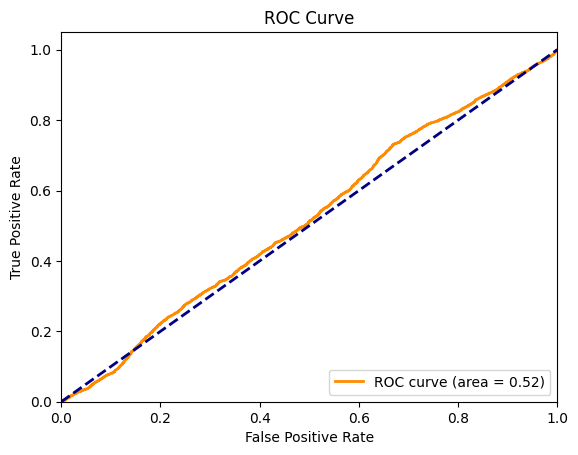

In [12]:
# Map the target variable to binary labels (e.g., 0 and 1) for ROC curve calculation
y_test_binary = y_test.map({1: 0, 3: 1})


# Calculate AUC-ROC
roc_auc = roc_auc_score(y_test, y_prob)

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, y_prob, pos_label=1)
pr_auc = auc(recall, precision)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_binary, y_prob)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # Fix this line
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()